## About this kernel

Hey, everyone!

This was my first solution to this competition. There is nothing revolutionary here as this is my first competition and I'm trying to learn with all the public kernels.

I decided to share this solution to help people that are beginners like me, to at least give them an idea of what to do and where to begin.

Later, I'll add a cell with all the advice people gave me in the discussions so we can talk more about it here. I'll also add a reference to the kernels I used here.

Please, give me some feedback if you can. I would love to hear what you believe could be improved in this kernel.

Hope you are enjoying this competition as much as I am. Good luck and I hope you like this kernel.

[**UPDATE**]  
In the comments section, @cebeci told me the merging process was wrong and it really was. I'm sorry about it, merging is now correct.  
Also in the comments, @lftuwujie told me the GPU makes almost no difference to LGBM. I tested it and he was (as expected) correct, so this was also changed.

Thank you for all the feedback and support. It's been really nice to learn with all of you.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from sklearn.metrics import roc_auc_score
import gc

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
%%time

folder_path = '../input/'
print('Loading data...')

train_identity = pd.read_csv(f'{folder_path}train_identity.csv', index_col='TransactionID')
print('\tSuccessfully loaded train_identity!')

train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv', index_col='TransactionID')
print('\tSuccessfully loaded train_transaction!')

test_identity = pd.read_csv(f'{folder_path}test_identity.csv', index_col='TransactionID')
print('\tSuccessfully loaded test_identity!')

test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv', index_col='TransactionID')
print('\tSuccessfully loaded test_transaction!')

sub = pd.read_csv(f'{folder_path}sample_submission.csv')
print('\tSuccessfully loaded sample_submission!')

print('Data was successfully loaded!\n')

Loading data...
	Successfully loaded train_identity!
	Successfully loaded train_transaction!
	Successfully loaded test_identity!
	Successfully loaded test_transaction!
	Successfully loaded sample_submission!
Data was successfully loaded!

CPU times: user 45.6 s, sys: 12 s, total: 57.5 s
Wall time: 57.6 s


In [4]:
def id_split(dataframe):
    dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0]
    dataframe['device_version'] = dataframe['DeviceInfo'].str.split('/', expand=True)[1]

    dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0]
    dataframe['version_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[1]

    dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
    dataframe['version_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[1]

    dataframe['screen_width'] = dataframe['id_33'].str.split('x', expand=True)[0]
    dataframe['screen_height'] = dataframe['id_33'].str.split('x', expand=True)[1]

    dataframe['id_34'] = dataframe['id_34'].str.split(':', expand=True)[1]
    dataframe['id_23'] = dataframe['id_23'].str.split(':', expand=True)[1]

    dataframe.loc[dataframe['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    dataframe.loc[dataframe['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    dataframe.loc[dataframe['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    dataframe.loc[dataframe['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    dataframe.loc[dataframe['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    dataframe.loc[dataframe['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    dataframe.loc[dataframe.device_name.isin(dataframe.device_name.value_counts()[dataframe.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    dataframe['had_id'] = 1
    gc.collect()
    
    return dataframe

In [5]:
train_identity = id_split(train_identity)
test_identity = id_split(test_identity)

In [6]:
print('Merging data...')
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print('Data was successfully merged!\n')

del train_identity, train_transaction, test_identity, test_transaction

print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

gc.collect()

Merging data...
Data was successfully merged!

Train dataset has 590540 rows and 442 columns.
Test dataset has 506691 rows and 441 columns.


35

In [7]:
useful_features = ['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
                   'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
                   'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M2', 'M3',
                   'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V17',
                   'V19', 'V20', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V44', 'V45', 'V46', 'V47', 'V48',
                   'V49', 'V51', 'V52', 'V53', 'V54', 'V56', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 'V71',
                   'V72', 'V73', 'V74', 'V75', 'V76', 'V78', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V92',
                   'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V138', 'V139', 'V140',
                   'V143', 'V145', 'V146', 'V147', 'V149', 'V150', 'V151', 'V152', 'V154', 'V156', 'V158', 'V159', 'V160', 'V161',
                   'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V169', 'V170', 'V171', 'V172', 'V173', 'V175', 'V176', 'V177',
                   'V178', 'V180', 'V182', 'V184', 'V187', 'V188', 'V189', 'V195', 'V197', 'V200', 'V201', 'V202', 'V203', 'V204',
                   'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V219', 'V220',
                   'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V231', 'V233', 'V234', 'V238', 'V239',
                   'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V249', 'V251', 'V253', 'V256', 'V257', 'V258', 'V259', 'V261',
                   'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276',
                   'V277', 'V278', 'V279', 'V280', 'V282', 'V283', 'V285', 'V287', 'V288', 'V289', 'V291', 'V292', 'V294', 'V303',
                   'V304', 'V306', 'V307', 'V308', 'V310', 'V312', 'V313', 'V314', 'V315', 'V317', 'V322', 'V323', 'V324', 'V326',
                   'V329', 'V331', 'V332', 'V333', 'V335', 'V336', 'V338', 'id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_09',
                   'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_32', 'id_33',
                   'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'device_name', 'device_version', 'OS_id_30', 'version_id_30',
                   'browser_id_31', 'version_id_31', 'screen_width', 'screen_height', 'had_id']

In [8]:
cols_to_drop = [col for col in train.columns if col not in useful_features]
cols_to_drop.remove('isFraud')
cols_to_drop.remove('TransactionDT')

In [9]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [10]:
columns_a = ['TransactionAmt', 'id_02', 'D15']
columns_b = ['card1', 'card4', 'addr1']

for col_a in columns_a:
    for col_b in columns_b:
        for df in [train, test]:
            df[f'{col_a}_to_mean_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].transform('mean')
            df[f'{col_a}_to_std_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].transform('std')

In [11]:
# New feature - log of transaction amount.
train['TransactionAmt_Log'] = np.log(train['TransactionAmt'])
test['TransactionAmt_Log'] = np.log(test['TransactionAmt'])

# New feature - decimal part of the transaction amount.
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)

# New feature - day of week in which a transaction happened.
train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
test['Transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)

# New feature - hour of the day in which a transaction happened.
train['Transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24
test['Transaction_hour'] = np.floor(test['TransactionDT'] / 3600) % 24

# Some arbitrary features interaction
for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'P_emaildomain__C2', 
                'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']:

    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

    le = LabelEncoder()
    le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
    train[feature] = le.transform(list(train[feature].astype(str).values))
    test[feature] = le.transform(list(test[feature].astype(str).values))

# Encoding - count encoding for both train and test
for feature in ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'id_36']:
    train[feature + '_count_full'] = train[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
    test[feature + '_count_full'] = test[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))

# Encoding - count encoding separately for train and test
for feature in ['id_01', 'id_31', 'id_33', 'id_36']:
    train[feature + '_count_dist'] = train[feature].map(train[feature].value_counts(dropna=False))
    test[feature + '_count_dist'] = test[feature].map(test[feature].value_counts(dropna=False))

In [12]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

In [13]:
# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499

for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails)
    test[c + '_bin'] = test[c].map(emails)
    
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])
    
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [14]:
%%time

for col in train.columns:
    if train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

CPU times: user 56.3 s, sys: 816 ms, total: 57.1 s
Wall time: 57.1 s


In [15]:
%%time
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 1542.85 MB
Memory usage after optimization is: 451.40 MB
Decreased by 70.7%
Memory usage of dataframe is 1322.76 MB
Memory usage after optimization is: 400.29 MB
Decreased by 69.7%
CPU times: user 1min 8s, sys: 1min 41s, total: 2min 49s
Wall time: 2min 49s


In [16]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']

X_test = test.drop(['TransactionDT'], axis=1)

del train, test
gc.collect()

28

In [17]:
from sklearn.model_selection import KFold
import lightgbm as lgb

In [18]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
         }

In [19]:
%%time

NFOLDS = 5
folds = KFold(n_splits=NFOLDS)

columns = X.columns
splits = folds.split(X, y)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X.shape[0])
score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += clf.predict(X_test) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")

Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.956413	valid_1's auc: 0.889487
[400]	training's auc: 0.977502	valid_1's auc: 0.902925
[600]	training's auc: 0.989208	valid_1's auc: 0.910864
[800]	training's auc: 0.994858	valid_1's auc: 0.915693
[1000]	training's auc: 0.997596	valid_1's auc: 0.918154
[1200]	training's auc: 0.998855	valid_1's auc: 0.919601
[1400]	training's auc: 0.999469	valid_1's auc: 0.920179
[1600]	training's auc: 0.999743	valid_1's auc: 0.920529
[1800]	training's auc: 0.999875	valid_1's auc: 0.920484
[2000]	training's auc: 0.999945	valid_1's auc: 0.920687
[2200]	training's auc: 0.999977	valid_1's auc: 0.921021
[2400]	training's auc: 0.999991	valid_1's auc: 0.921159
[2600]	training's auc: 0.999996	valid_1's auc: 0.921227
[2800]	training's auc: 0.999998	valid_1's auc: 0.921263
[3000]	training's auc: 0.999999	valid_1's auc: 0.921351
[3200]	training's auc: 1	valid_1's auc: 0.921393
[3400]	training's auc: 1	valid_1's auc: 0.921386
[36

In [20]:
sub['isFraud'] = y_preds
sub.to_csv("submission.csv", index=False)

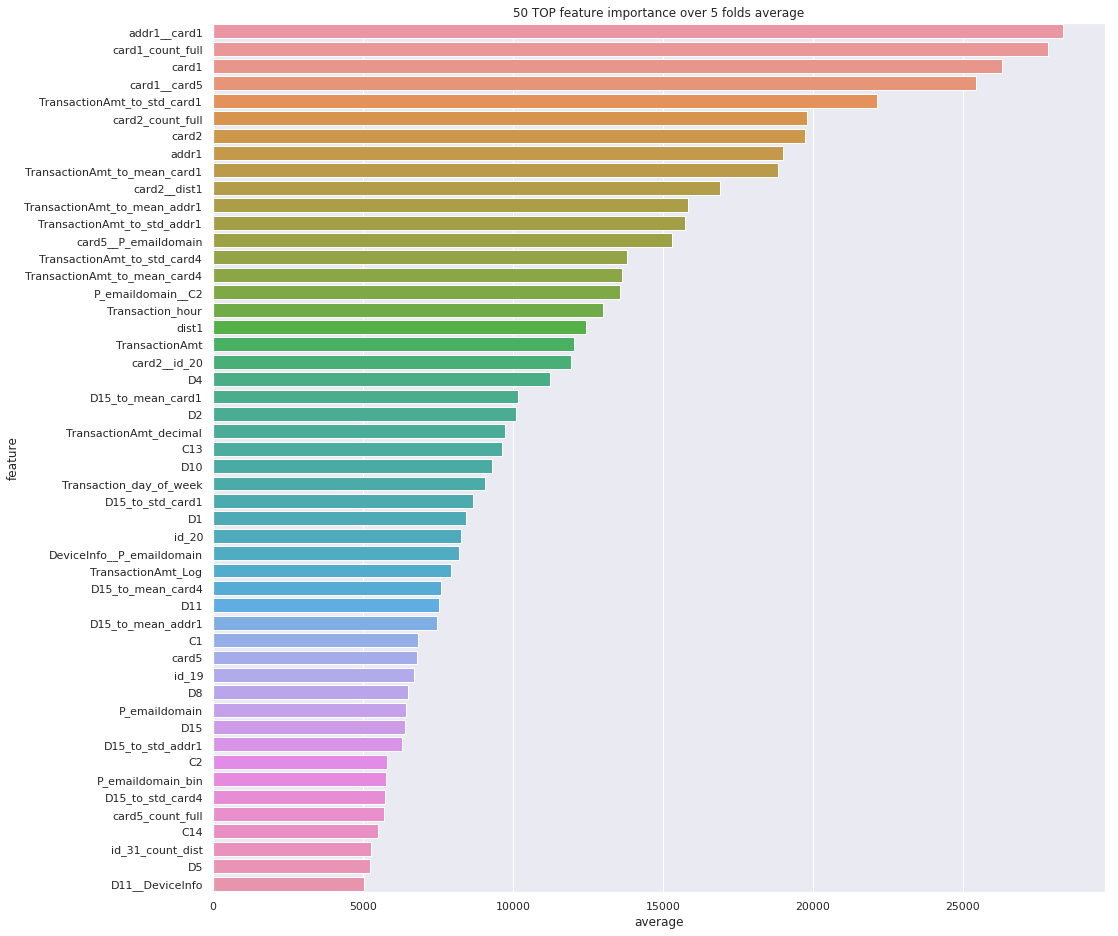

In [21]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));